In [20]:
import os
import sys
import pandas as pd
import numpy as np
# import random
import matplotlib.pyplot as plt
from similar_companies_choice import get_similar_comp_ranking
from data_preparation import get_financial_data
from data_preparation import compute_ratios
from sklearn.linear_model import LinearRegression

os.chdir(sys.path[0])

In [21]:
# studied_comp_ticker = "MMM" # for demo
studied_comp_ticker = "FB"
similarity_ranking = get_similar_comp_ranking(studied_comp_ticker) 

Number of missing values per column in the dataset:

Ticker                   0
GICS Sector              0
GICS Sub-Industry        0
CUR_MKT_CAP              5
Headquarters Location    0
dtype: int64


In [39]:
print("List of companies ranked similarity of sector/sub-industry, geography, and market cap :")
similarity_ranking.head(10)

List of companies ranked similarity of sector/sub-industry, geography, and market cap :


Ticker
GOOGL    0.119575
GOOG     0.119575
TWTR     0.555828
MTCH     1.145641
DIS      1.199356
NFLX     1.251592
ATVI     1.437222
EA       1.518902
LYV      1.588514
CMCSA    1.820906
Name: similarity_score, dtype: float64

In [23]:
group_size = 5
print(f"\nThese {group_size} companies will be chosen to form the group to compare with, based on similarity :")
symbols_comp_group = similarity_ranking[:group_size].index.tolist()
print(symbols_comp_group)


These 5 companies will be chosen to form the group to compare with, based on similarity :
['GOOGL', 'GOOG', 'TWTR', 'MTCH', 'DIS']


In [24]:
companies_data = get_financial_data(symbols_comp_group + [studied_comp_ticker])

In [25]:
companies_data

,Ticker,CUR_MKT_CAP,CURR_ENTP_VAL,EBIT,EBITDA,GROSS_PROFIT,PE_RATIO
24,GOOGL,1.798880e+12,1.684738e+06,41224.000,57188.000,97795.000,30.786899
25,GOOG,1.798880e+12,1.684738e+06,41224.000,57188.000,97795.000,NaN
305,MTCH,3.190371e+10,3.523730e+04,745.715,815.974,1755.436,57.789714
311,FB,8.714140e+11,8.265580e+05,32671.000,40924.000,69273.000,22.359744
455,TWTR,2.999337e+10,2.803180e+04,26.658,713.595,2349.961,84.258995
485,DIS,2.602720e+11,3.162972e+05,3005.000,8969.000,22287.000,90.276507


In [26]:
print("Number of missing values per column :\n")
print(companies_data.isnull().sum())

Number of missing values per column :

Ticker           0
CUR_MKT_CAP      0
CURR_ENTP_VAL    0
EBIT             0
EBITDA           0
GROSS_PROFIT     0
PE_RATIO         1
dtype: int64


In [27]:
# droping rows with NaN
# nbr_of_na = companies_data.isna().sum().sum()
# if (nbr_of_na > 0):
#     print(f"{nbr_of_na} missing values. Rows with NaN will be dropped.")
#     companies_data = companies_data.dropna(axis='rows')

In [28]:
companies_data = compute_ratios(companies_data)

In [29]:
companies_data

,Ticker,CUR_MKT_CAP,CURR_ENTP_VAL,EBIT,EBITDA,GROSS_PROFIT,PE_RATIO,EV_EBIT_ratio,EV_EBITDA_ratio,EV_GROSS_PROFIT_ratio
24,GOOGL,1.798880e+12,1.684738e+06,41224.000,57188.000,97795.000,30.786899,40.867882,29.459634,17.227236
25,GOOG,1.798880e+12,1.684738e+06,41224.000,57188.000,97795.000,NaN,40.867882,29.459634,17.227236
305,MTCH,3.190371e+10,3.523730e+04,745.715,815.974,1755.436,57.789714,47.253041,43.184344,20.073248
311,FB,8.714140e+11,8.265580e+05,32671.000,40924.000,69273.000,22.359744,25.299439,20.197390,11.931892
455,TWTR,2.999337e+10,2.803180e+04,26.658,713.595,2349.961,84.258995,1051.534143,39.282502,11.928622
485,DIS,2.602720e+11,3.162972e+05,3005.000,8969.000,22287.000,90.276507,105.256975,35.265605,14.192005


In [30]:
companies_data = companies_data.set_index("Ticker")

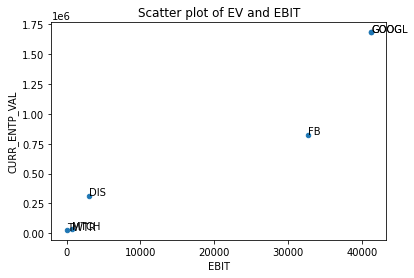

In [31]:
#Scatter plot
stat = "EBIT"
ax = companies_data.plot.scatter(stat, "CURR_ENTP_VAL", title=f"Scatter plot of EV and {stat}")

# Annotate each data point
for i, txt in enumerate(companies_data.index):
   ax.annotate(txt, (companies_data[stat].iat[i]+0.05, companies_data["CURR_ENTP_VAL"].iat[i]))

In [32]:
#calcul des moyennes
print("\nAverages :")
# averages = companies_data.drop()
averages = companies_data.mean(axis=0)
print(averages)


Averages :
CUR_MKT_CAP              7.985572e+11
CURR_ENTP_VAL            7.625999e+05
EBIT                     1.981606e+04
EBITDA                   2.763309e+04
GROSS_PROFIT             4.854257e+04
PE_RATIO                 5.709437e+01
EV_EBIT_ratio            2.185132e+02
EV_EBITDA_ratio          3.280818e+01
EV_GROSS_PROFIT_ratio    1.543004e+01
dtype: float64


# *** TO DO : CHECK EACH COLUMN'S UNIT, TO MAKE SURE EVERYTHING IS ON SAME SCALE (either thousands or millions of dollars) ***

### CCA USING RATIOS

In [33]:
denominators = ["EBIT", "EBITDA", "GROSS_PROFIT"]

for i in range(len(denominators)):
    ratio_to_be_used = f"EV_{denominators[i]}_ratio"
    estimated_EV = averages.loc[ratio_to_be_used] * companies_data.loc[studied_comp_ticker, denominators[i]]

    print("*** ESTIMATIONS ***\n(Values are in millions of dollars)\n")
    print(f"Real EV of {studied_comp_ticker}: {companies_data.loc[studied_comp_ticker, 'CURR_ENTP_VAL']}")
    print(f"Estimated EV of {studied_comp_ticker} (using avg {ratio_to_be_used}): {estimated_EV} ")
    print(f"Real EV / Estimated EV : {companies_data.loc[studied_comp_ticker, 'CURR_ENTP_VAL'] / estimated_EV}")
    print("\n\n")

*** ESTIMATIONS ***
(Values are in millions of dollars)

Real EV of FB: 826557.986
Estimated EV of FB (using avg EV_EBIT_ratio): 7139045.644956224 
Real EV / Estimated EV : 0.11577989931805072



*** ESTIMATIONS ***
(Values are in millions of dollars)

Real EV of FB: 826557.986
Estimated EV of FB (using avg EV_EBITDA_ratio): 1342642.1585833407 
Real EV / Estimated EV : 0.6156204620240172



*** ESTIMATIONS ***
(Values are in millions of dollars)

Real EV of FB: 826557.986
Estimated EV of FB (using avg EV_GROSS_PROFIT_ratio): 1068885.157004489 
Real EV / Estimated EV : 0.7732897969286037





### CCA USING LINEAR REGRESSION

Estimation using simple linear regression


Coefs ligne de regression :
a=17.412
intercept=-23221.1597

Real EV of FB: 826557.986
Estimated EV of FB with regression model (using GROSS_PROFIT): 1182957.1149609913
Real EV / Estimated EV : 0.6987218518291395



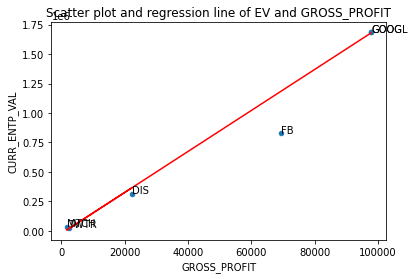

In [34]:
stat_used = "GROSS_PROFIT"
ax = companies_data.plot.scatter(stat_used, "CURR_ENTP_VAL", title=f"Scatter plot and regression line of EV and {stat_used}")
# Annotate each data point
for i, txt in enumerate(companies_data.index):
   ax.annotate(txt, (companies_data[stat_used].iat[i]+0.05, companies_data["CURR_ENTP_VAL"].iat[i]))

X = companies_data[companies_data.index != studied_comp_ticker][[stat_used]].reset_index(drop=True)
Y = companies_data[companies_data.index != studied_comp_ticker]["CURR_ENTP_VAL"].reset_index(drop=True)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
print(f"\nCoefs ligne de regression :\na={round(linear_regressor.coef_[0], 4)}\nintercept={round(linear_regressor.intercept_, 4)}\n")

#EV estimation
studied_comp_row_single_var = companies_data[companies_data.index == studied_comp_ticker][[stat_used]].reset_index(drop=True)
estimated_EV = linear_regressor.predict(studied_comp_row_single_var)[0]

print(f"Real EV of {studied_comp_ticker}: {companies_data.loc[studied_comp_ticker, 'CURR_ENTP_VAL']}")
print(f"Estimated EV of {studied_comp_ticker} with regression model (using {stat_used}): {estimated_EV}")
print(f"Real EV / Estimated EV : {companies_data.loc[studied_comp_ticker, 'CURR_ENTP_VAL'] / estimated_EV}\n")

plt.plot(X, X*linear_regressor.coef_ + linear_regressor.intercept_, color='red')
plt.show()

Estimation using multiple linear regression

In [35]:
X = companies_data[companies_data.index != studied_comp_ticker][["EBIT", "EBITDA", "GROSS_PROFIT"]].reset_index(drop=True)
Y = companies_data[companies_data.index != studied_comp_ticker]["CURR_ENTP_VAL"].reset_index(drop=True)

linear_regressor2 = LinearRegression()
linear_regressor2.fit(X, Y)
print(f"\nCoefs ligne de regression :\ncoefs={linear_regressor2.coef_}\nintercept={round(linear_regressor2.intercept_, 4)}\n")

#EV estimation
studied_comp_row_multi_var = companies_data[companies_data.index == studied_comp_ticker][["EBIT", "EBITDA", "GROSS_PROFIT"]].reset_index(drop=True)
estimated_EV = linear_regressor2.predict(studied_comp_row_multi_var)[0]

print(f"Real EV of {studied_comp_ticker}: {companies_data.loc[studied_comp_ticker, 'CURR_ENTP_VAL']}")
print(f"Estimated EV of {studied_comp_ticker} with regression model (using all stats): {estimated_EV}")
print(f"Real EV / Estimated EV : {companies_data.loc[studied_comp_ticker, 'CURR_ENTP_VAL'] / estimated_EV}\n")


Coefs ligne de regression :
coefs=[ 39.81406619 -46.9451839   27.94983818]
intercept=-5210.7474

Real EV of FB: 826557.986
Estimated EV of FB with regression model (using all stats): 1310539.043324318
Real EV / Estimated EV : 0.630700771724702

